# Distance to Ust Ishim individual

---

Variables to allow differentation of file names for analyses based on different calling criteria. Should be commented out when run in batch with `slurm-jupyter-run.py`

**NB:** comment out the cell below if you want to run using `slurm-jupyter-run.py`. Otherwise it will overwrite variables set by `slurm-jupyter-run.py`.

In [2]:
from nb_parameters import extract_parameter_code
exec(extract_parameter_code('nb_parameters.ipynb', '5e-05_25%'))

----


Figure out if swept and non-swept haplotypes have a different relation to Ust Ishim individual


In [3]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import numpy as np
import pandas
import scipy
from pandas import DataFrame, Series

numpy.random.seed(7)

Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore deprecation warnings from mainly seaborn:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [6]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [7]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [8]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [9]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def bootstrap_se(sr, n=10000):
    means = list()
    for i in range(n):
        means.append(numpy.mean(sr.sample(frac=1, replace=True)))
    return numpy.std(means)

In [10]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

## Load meta data

In [11]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir, include_ust_ishim=True)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load data for each individual

In [12]:
# #all_male_indiv_dist = pandas.read_hdf(results_dir / 'all_male_indiv_dist.hdf')
# sweep_data = (pandas.read_hdf(results_dir / 'sweep_data.hdf')
#               .loc[lambda df: df.not_missing == True] # only include windows where enough individuals are called
#              )
# sweep_data.head()

## Called sweeps in Ust ishim using cliques

Load the clique data that includes Ust ishim and see how often Ust ishim is called and how it overlaps the extended regions.

**Note that we demand the same same number of called bases for Ust ishim as for the remaining individuals. That filters away windows that can then not be called in Ust ishim**

So we start by loading all dist data to see how many Ust ishim windows are missing in the extended regions compared to other individuals:

In [13]:
ust_ishim_dist_twice = pandas.read_hdf(steps_dir / 'male_dist_admix_masked_stores/male_dist_data_with_ust_ishim_chrX_100kb_twice.hdf')


## Missing windows in Ust ishim compared to other individuals

Mean uncalled over pairs including each individual. A window is considered missing if this mean falls below cutoff:

In [14]:
ust_ishim_dist_twice.groupby('region_1').uncalled.mean()

region_1
Africa                31268.681853
WestEurasia           31009.992394
SouthAsia             30749.751693
CentralAsiaSiberia    30800.258545
Oceania               31755.964955
EastAsia              31169.435355
America               30817.761191
Ust_Ishim             51520.739750
Name: uncalled, dtype: float64

Plot distribution of uncalled bases in windows for Ust ishim and for all others:

In [15]:
ust_ishim_uncalled = ust_ishim_dist_twice.loc[ust_ishim_dist_twice.indiv_1 == 'Ust_Ishim'].uncalled
other_indiv_uncalled = ust_ishim_dist_twice.loc[ust_ishim_dist_twice.indiv_1 != 'Ust_Ishim'].uncalled

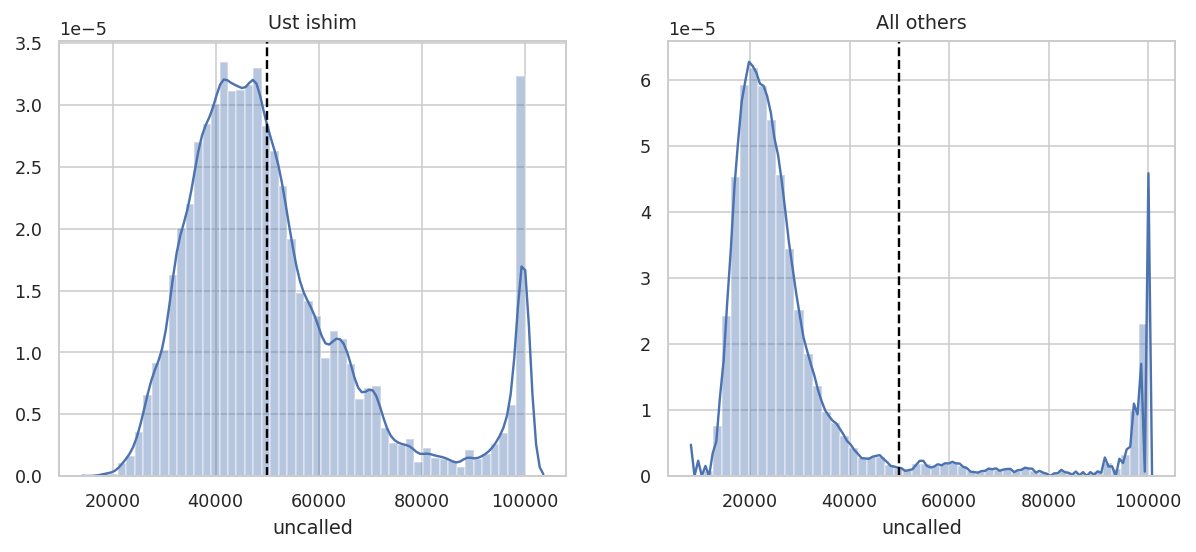

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(ust_ishim_uncalled, ax=ax1)
ax1.axvline(analysis_globals.max_uncalled_bases, linestyle='dashed', color='black')
ax1.set_title("Ust ishim")
sns.distplot(other_indiv_uncalled, ax=ax2)
ax2.axvline(analysis_globals.max_uncalled_bases, linestyle='dashed', color='black')
ax2.set_title("All others") ;

In the workflow script `build_male_dist_admix_masked_data.py`, we find cutoff that gives Ust ishim the same number of called windows as the average other individual. Code in the cell below is copied from that script to show how:

In [17]:
ust_ishim_uncalled = ust_ishim_dist_twice.loc[ust_ishim_dist_twice.indiv_1 == 'Ust_Ishim'].uncalled
other_indiv_uncalled = ust_ishim_dist_twice.loc[ust_ishim_dist_twice.indiv_1 != 'Ust_Ishim'].uncalled
quant = (other_indiv_uncalled <= analysis_globals.max_uncalled_bases).sum() / other_indiv_uncalled.size
ust_ishim_max_uncalled_bases = int(np.quantile(ust_ishim_uncalled, quant))
ust_ishim_max_uncalled_bases

72783

Adjusted cutoff retaining the same proportion of windows:

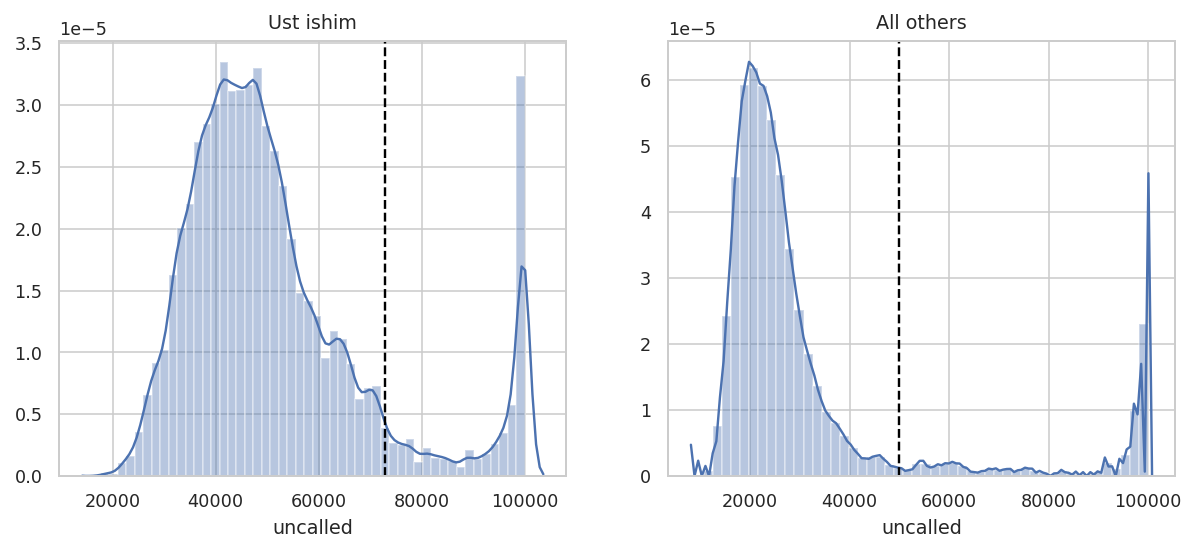

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(ust_ishim_uncalled, ax=ax1)
ax1.axvline(ust_ishim_max_uncalled_bases, linestyle='dashed', color='black')
ax1.set_title("Ust ishim")
sns.distplot(other_indiv_uncalled, ax=ax2)
ax2.axvline(analysis_globals.max_uncalled_bases, linestyle='dashed', color='black')
ax2.set_title("All others") ;

In [19]:
indiv_mask = ust_ishim_dist_twice.groupby(['indiv_1', 'start']).uncalled.agg('mean').to_frame('mean_uncalled').reset_index()

In [20]:
# indiv_mask['missing'] = indiv_mask.mean_uncalled >= analysis_globals.max_uncalled_bases
# indiv_mask['missing_ust_ishim_cut'] = indiv_mask.mean_uncalled >= ust_ishim_max_uncalled_bases
# missing_counts = indiv_mask.groupby('indiv_1').missing.sum()

# print(missing_counts['Ust_Ishim'])
# plt.hist(missing_counts, bins=np.linspace(0, 1000, 100))
# plt.axvline(missing_counts['Ust_Ishim'], color='orange') ;

## Load extended peak regions

In [21]:
extended_peak_regions = (pandas.read_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')
                         .loc[lambda df: df.peak_prop_swept >= analysis_globals.min_prop_swept]
                        )
extended_peak_regions

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,swept_indivs
0,19850000.0,19800000,19900000,0.828571,19600000,20100000,0.771429,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."
1,21250000.0,21200000,21300000,0.814286,21100000,21600000,0.785714,"['B_Australian-4', 'B_Crete-2', 'B_French-3', ..."
2,36300000.0,36200000,36400000,0.664286,36000000,36400000,0.635714,"['B_Crete-2', 'B_Dai-4', 'B_French-3', 'B_Han-..."
3,37500000.0,37300000,37700000,0.507143,37200000,37700000,0.500000,"['B_Crete-2', 'B_Dai-4', 'B_Han-3', 'B_Karitia..."
4,49750000.0,49500000,50000000,0.528571,49500000,50000000,0.528571,"['B_Australian-4', 'B_French-3', 'B_Papuan-15'..."
6,54300000.0,54200000,54400000,0.757143,54000000,54400000,0.735714,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."
7,64800000.0,64700000,64900000,0.778571,64600000,65100000,0.714286,"['B_Crete-2', 'B_Dai-4', 'B_French-3', 'B_Han-..."
10,77050000.0,76900000,77200000,0.564286,76700000,77300000,0.550000,"['B_Australian-4', 'B_French-3', 'B_Sardinian-..."
11,98750000.0,98700000,98800000,0.750000,98500000,98900000,0.714286,"['B_Dai-4', 'B_French-3', 'B_Han-3', 'B_Kariti..."
12,110900000.0,110700000,111100000,0.992857,110200000,111100000,0.950000,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."


## Load sweep data

Load clique data including Ust ishim, produced with an adjusted cutoff:

In [22]:
ust_ishim_sweep_data = pandas.read_hdf(clique_data_with_ust_ishim_file_name)

See how many windows are swept in each individual compared to Ust ishim:

131.81560283687944 73


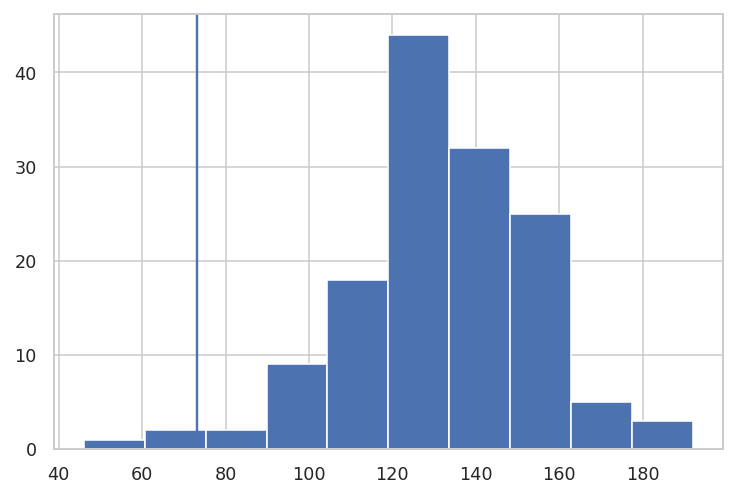

In [23]:
nr_win_swept = ust_ishim_sweep_data.loc[(ust_ishim_sweep_data.region_1 != 'Africa') & \
                                        (ust_ishim_sweep_data.swept == True)].groupby('indiv_1').size()
print(nr_win_swept.mean(), nr_win_swept['Ust_Ishim'])
plt.hist(nr_win_swept)
plt.axvline(nr_win_swept['Ust_Ishim']) ;

So we can see that Ust ishim has about half as many windows swept.

Check the mean uncalled positions for piars including Ust ishim in extended regions:

In [24]:

lst = list()
for tup in extended_peak_regions.itertuples():
    start = tup.start_pos
    end = tup.end_pos
    
    # get distances between swept haplotypes and ust ishim
    df = ust_ishim_dist_twice.loc[lambda df: (df.region_1 != 'Africa') & (df.start >= tup.start_pos) & (df.end <= tup.end_pos)]
    
    print(">>>", start, end, df.loc[df.indiv_1 == 'Ust_Ishim'].uncalled.mean(),
         df.uncalled.mean(), df.loc[df.indiv_1 == 'Ust_Ishim'].uncalled.mean() / df.uncalled.mean())

>>> 19600000 20100000 39256.38148148148 22510.94329743455 1.7438798971145433
>>> 21100000 21600000 43352.450617283954 21626.9487785658 2.004556956284561
>>> 36000000 36400000 39480.390432098764 20987.66000131337 1.8811239761663832
>>> 37200000 37700000 47471.38518518519 27896.833482181944 1.701676472188349
>>> 49500000 50000000 41635.427160493826 26299.761614569652 1.583110439199892
>>> 54000000 54400000 52916.385802469136 29987.158118816216 1.764634901140078
>>> 64600000 65100000 54993.92469135803 29143.360984152 1.8870138115251505
>>> 76700000 77300000 56676.24794238683 28701.009952426815 1.9747126681719633
>>> 98500000 98900000 47191.18981481482 20717.488114000524 2.2778432189819298
>>> 110200000 111100000 36483.92798353909 19830.413035441536 1.8397966758601483
>>> 114000000 114400000 44441.70216049383 24231.773870501707 1.8340259527840206
>>> 126800000 127400000 48837.05144032922 20737.18454309313 2.3550473468972055
>>> 129700000 130200000 32733.97037037037 19580.682628491377 1.671

It seems the proportion of uncalled positions for piars including Ust ishim is about twice that for other pairs.

### See how many extended regions contain sweeps in Ust ishim:

In [25]:

lst = list()
for tup in extended_peak_regions.itertuples():
    start = tup.start_pos
    end = tup.end_pos
    
    # get distances between swept haplotypes and ust ishim
    df = (ust_ishim_sweep_data
          .copy()
          .loc[lambda df: (df.region_1 != 'Africa') & (df.start >= tup.start_pos) & (df.end <= tup.end_pos)]
         )
    df['peak_pos'] = tup.pos
    lst.append(df)

#    df.loc[(df.indiv_1 == 'Ust_Ishim') & (df.uncalled >= ust_ishim_max_uncalled_bases)].uncalled.size
    
    print(">>>", start, end, df.loc[df.indiv_1 == 'Ust_Ishim'].swept.sum(), 
                      df.loc[df.indiv_1 == 'Ust_Ishim'].clade_size.max())
    
windows_in_extended_regions = pandas.concat(lst)

>>> 19600000 20100000 0 nan
>>> 21100000 21600000 5 53.0
>>> 36000000 36400000 4 54.0
>>> 37200000 37700000 0 nan
>>> 49500000 50000000 0 nan
>>> 54000000 54400000 0 nan
>>> 64600000 65100000 0 nan
>>> 76700000 77300000 0 nan
>>> 98500000 98900000 4 57.0
>>> 110200000 111100000 7 77.0
>>> 114000000 114400000 4 47.0
>>> 126800000 127400000 6 52.0
>>> 129700000 130200000 4 39.0
>>> 131200000 131600000 0 nan


In [26]:
df.loc[df.indiv_1 == 'Ust_Ishim']

,indiv_1,start,end,pop_1,region_label_1,region_id_1,region_1,mean_dist,mean_dist_af,mean_dist_to_africans,...,clade_mean_dist_af,clade_size,clade_size_af,run_id,run_length,swept,run_id_af,run_length_af,swept_af,peak_pos
252736,Ust_Ishim,131200000,131300000,Ust_Ishim,Ust_Ishim,7,Ust_Ishim,0.000208,0.000189,0.000398,...,0.000034,NaN,50.0,19,251,False,28,8,True,131450000.0
252737,Ust_Ishim,131300000,131400000,Ust_Ishim,Ust_Ishim,7,Ust_Ishim,0.000146,0.000127,0.000392,...,0.000034,NaN,50.0,19,251,False,28,8,True,131450000.0
252738,Ust_Ishim,131400000,131500000,Ust_Ishim,Ust_Ishim,7,Ust_Ishim,0.000151,0.000131,0.000290,...,0.000034,NaN,50.0,19,251,False,28,8,True,131450000.0
252739,Ust_Ishim,131500000,131600000,Ust_Ishim,Ust_Ishim,7,Ust_Ishim,0.000088,0.000069,0.000202,...,0.000033,NaN,50.0,19,251,False,28,8,True,131450000.0


### How many sweeps (extended regions) are each indiviudal part of

In [28]:
indiv_mask = ust_ishim_dist_twice.groupby(['indiv_1', 'start']).uncalled.agg('mean').to_frame('mean_uncalled').reset_index()


indiv_mask['missing'] = indiv_mask.mean_uncalled >= analysis_globals.max_uncalled_bases
indiv_mask['missing_ust_ishim_cut'] = indiv_mask.mean_uncalled >= ust_ishim_max_uncalled_bases


missing_counts = indiv_mask.groupby('indiv_1').missing.sum()
# print(missing_counts['Ust_Ishim'])
# plt.hist(missing_counts, bins=np.linspace(0, 1000, 100))
# plt.axvline(missing_counts['Ust_Ishim'], color='orange') ;

In [29]:
sweep_inclusion = (windows_in_extended_regions
                   .merge(indiv_mask)
                   .groupby(['indiv_1', 'peak_pos'])
                   .agg('sum')[['swept', 'missing', 'missing_ust_ishim_cut']]
                   .reset_index()
                  )

How many are Ust ishim part of:

In [30]:
(sweep_inclusion[sweep_inclusion.indiv_1 == 'Ust_Ishim']
 .sort_values(['swept', 'missing', 'missing_ust_ishim_cut'])
)

,indiv_1,peak_pos,swept,missing,missing_ust_ishim_cut
1960,Ust_Ishim,19850000.0,0,0,0
1973,Ust_Ishim,131450000.0,0,0,0
1964,Ust_Ishim,49750000.0,0,1,0
1963,Ust_Ishim,37500000.0,0,2,0
1965,Ust_Ishim,54300000.0,0,2,0
1966,Ust_Ishim,64800000.0,0,3,1
1967,Ust_Ishim,77050000.0,0,4,0
1962,Ust_Ishim,36300000.0,4,0,0
1972,Ust_Ishim,129900000.0,4,0,0
1970,Ust_Ishim,114150000.0,4,1,0


In [34]:
sweep_inclusion.loc[(sweep_inclusion.indiv_1 == 'Ust_Ishim') & (sweep_inclusion.swept > 0), 'peak_pos'].values


array([2.1250e+07, 3.6300e+07, 9.8750e+07, 1.1090e+08, 1.1415e+08,
       1.2705e+08, 1.2990e+08])

In [ ]:
df.loc[df.swept == True]

What is the distribution of sweep inclusion for all individuals:

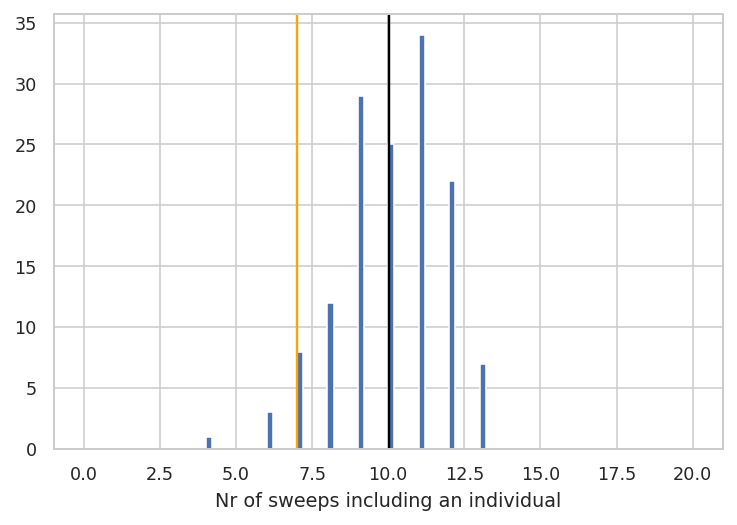

In [51]:
#sweep_inclusion_count = sweep_inclusion

sweep_inclusion_count = (windows_in_extended_regions
                   .merge(indiv_mask)
                   .groupby(['indiv_1', 'peak_pos'])
                   .agg('any')[['swept', 'missing']]
                   .reset_index()
                  ).groupby('indiv_1').agg('sum').swept.to_frame('included').reset_index()

plt.hist(sweep_inclusion_count.included, bins=numpy.linspace(0,20,101)) 
plt.xlabel('Nr of sweeps including an individual')
plt.axvline(x=sweep_inclusion_count.included.mean(), label='Mean inclusion', color='black')
plt.axvline(x=7, color='orange', label="Ust'ishim inclusion") ;

In [52]:
sweep_inclusion_count.included.mean()

10.02836879432624

In [53]:
sweep_inclusion_count.included.quantile([0.025, 0.975]),

(0.025     6.5
 0.975    13.0
 Name: included, dtype: float64,)

In [36]:
sum(sweep_inclusion_count.included < 7) / len(sweep_inclusion_count.included), len(sweep_inclusion_count.included)

(0.028368794326241134, 141)

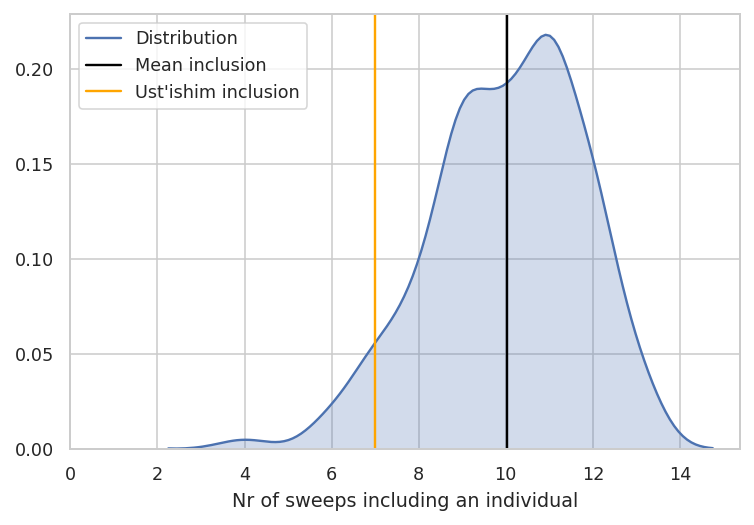

In [37]:
sns.kdeplot(sweep_inclusion_count.included, shade=True, label='Distribution')
plt.axvline(x=sweep_inclusion_count.included.mean(), label='Mean inclusion', color='black')
plt.axvline(x=7, color='orange', label="Ust'ishim inclusion")
plt.xlabel('Nr of sweeps including an individual')
plt.xlim(left=0)
plt.legend() ;

## Conclusion

Ust ishim is part of ~7/14 half of the sweeps, compared to other individuals which this is ~10/14. We adjust the cutoff so that the same number of windows are included in the analysis. The larger number of allowed uncalled positons in pairwise distances including Ust ishim means that the uncalled bases for pairs with ust ishim is about twice that for other pairs. This means that Ust ishim distances are based on fewer posisitons, increasing the variance, thus increasig the propotion that falls about the min dist cutoff.

To take this into account we also inspect the Tishkoff plots to see how many extended regions Ust ishim falls in the same clade as the swept ones.

**Idea:**

We could try to downsample an individual that is included in 14 sweeps so that is has as the same number of uncalled bases as Ust ishim - and then call sweeps to see how many that individual is then part of.